In [2]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import SparsePauliOp, DensityMatrix, Statevector, state_fidelity
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.circuit import Parameter # To enable parameterized circuits
from qiskit.circuit.library import SwapGate
from qiskit_aer import AerSimulator

import numpy as np
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_bloch_multivector
from qiskit.visualization import plot_bloch_vector
from math import pi, sqrt
from matplotlib import pyplot as plt

# 01 (Alice X Gate)

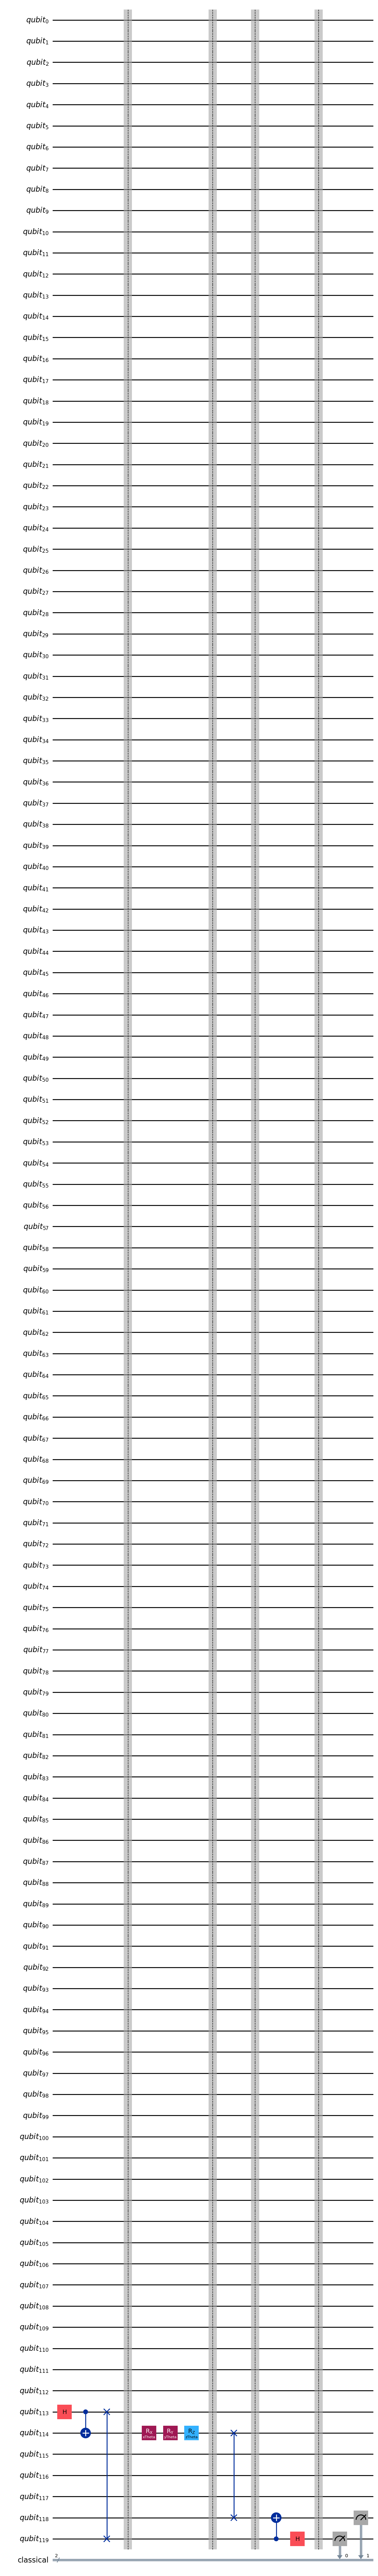

In [31]:
start0 = 113
start1 = start0 + 1
end0 = 118

xTheta = Parameter('xTheta')
yTheta = Parameter('yTheta')
zTheta = Parameter('zTheta')


num_data_qubits = end0+2
num_data_cbits = 2

# Create qubit and classical data bit registers (you can create and name additional registers if it's useful for bookkeeping)
data_qubits = QuantumRegister(num_data_qubits, "qubit")
classical_data = ClassicalRegister(num_data_cbits, "classical")

# Create circuit object
qc = QuantumCircuit(data_qubits,  classical_data)

# Create empty lists to store qubits and classical bits for convenient access
qdata = []; cdata = []; 

# Store qubits from data_qubit register in list for convenient access
qdata[:] = data_qubits

# Store classical bits from classical_data register in list for convenient access
cdata[:] = classical_data
 
# Perform a controlled-X gate on qubit 1, controlled by qubit 0
qc.h(start0) #This is state to be transported
qc.cx(start0,start1)
qc.swap(start0,end0+1)
qc.barrier()

# qc.id(1)
#qc.u(zTheta, xTheta,yTheta, 1)
qc.rx(xTheta,start1)
qc.ry(yTheta,start1)
qc.rz(zTheta,start1)
# qc.x(1)
# qc.z(1)
qc.barrier()

# for i in range (1, bNum + 1):
#     qc.swap(i, i+1)
qc.swap(start1, end0)
qc.barrier()

qc.cx(end0+1, end0)
qc.h(end0+1)
qc.barrier()

qc.measure(end0 + 1, 0)
qc.measure(end0 + 0, 1)


qc.draw('mpl')

In [4]:

def send(bits2):
    params = {zTheta: 0,     yTheta: 0,     xTheta: 0}
    # if (bits2=='00'):
    #     params = {zTheta: 0,     yTheta: 0,     xTheta: 0}
    if (bits2=='10'):
        params = {zTheta: 0,     yTheta: 0,     xTheta: pi}
    if (bits2 == '01'):
        params = {zTheta: pi,     yTheta: 0, xTheta: 0}
    if (bits2=='11'):
        params = {zTheta: pi, yTheta: 0,     xTheta: pi}
    return params
def send_string(bits):
    param_sets = []
    if (len(bits)%2==1):
        bits=f"{bits}0"
    for i in range(0,len(bits),2):
        bits2 = bits[i:i+2]
        param_sets.append(send(bits2))
    return param_sets



In [5]:
service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='ibm-q/open/main',
    token='d0eb190d4a2030a50f46ce9ceb962e604fe8a5b75928d54117d32acbe12a6b942d981e1596fd9b689d78e7181d1f41f15ed80afc790acdb8effa7513bae38773' #This is Logans API key
)

ERROR:stevedore.extension:Could not load 'ibm_backend': cannot import name 'ProviderV1' from 'qiskit.providers' (/opt/conda/lib/python3.11/site-packages/qiskit/providers/__init__.py)
ERROR:stevedore.extension:Could not load 'ibm_dynamic_circuits': cannot import name 'ProviderV1' from 'qiskit.providers' (/opt/conda/lib/python3.11/site-packages/qiskit/providers/__init__.py)


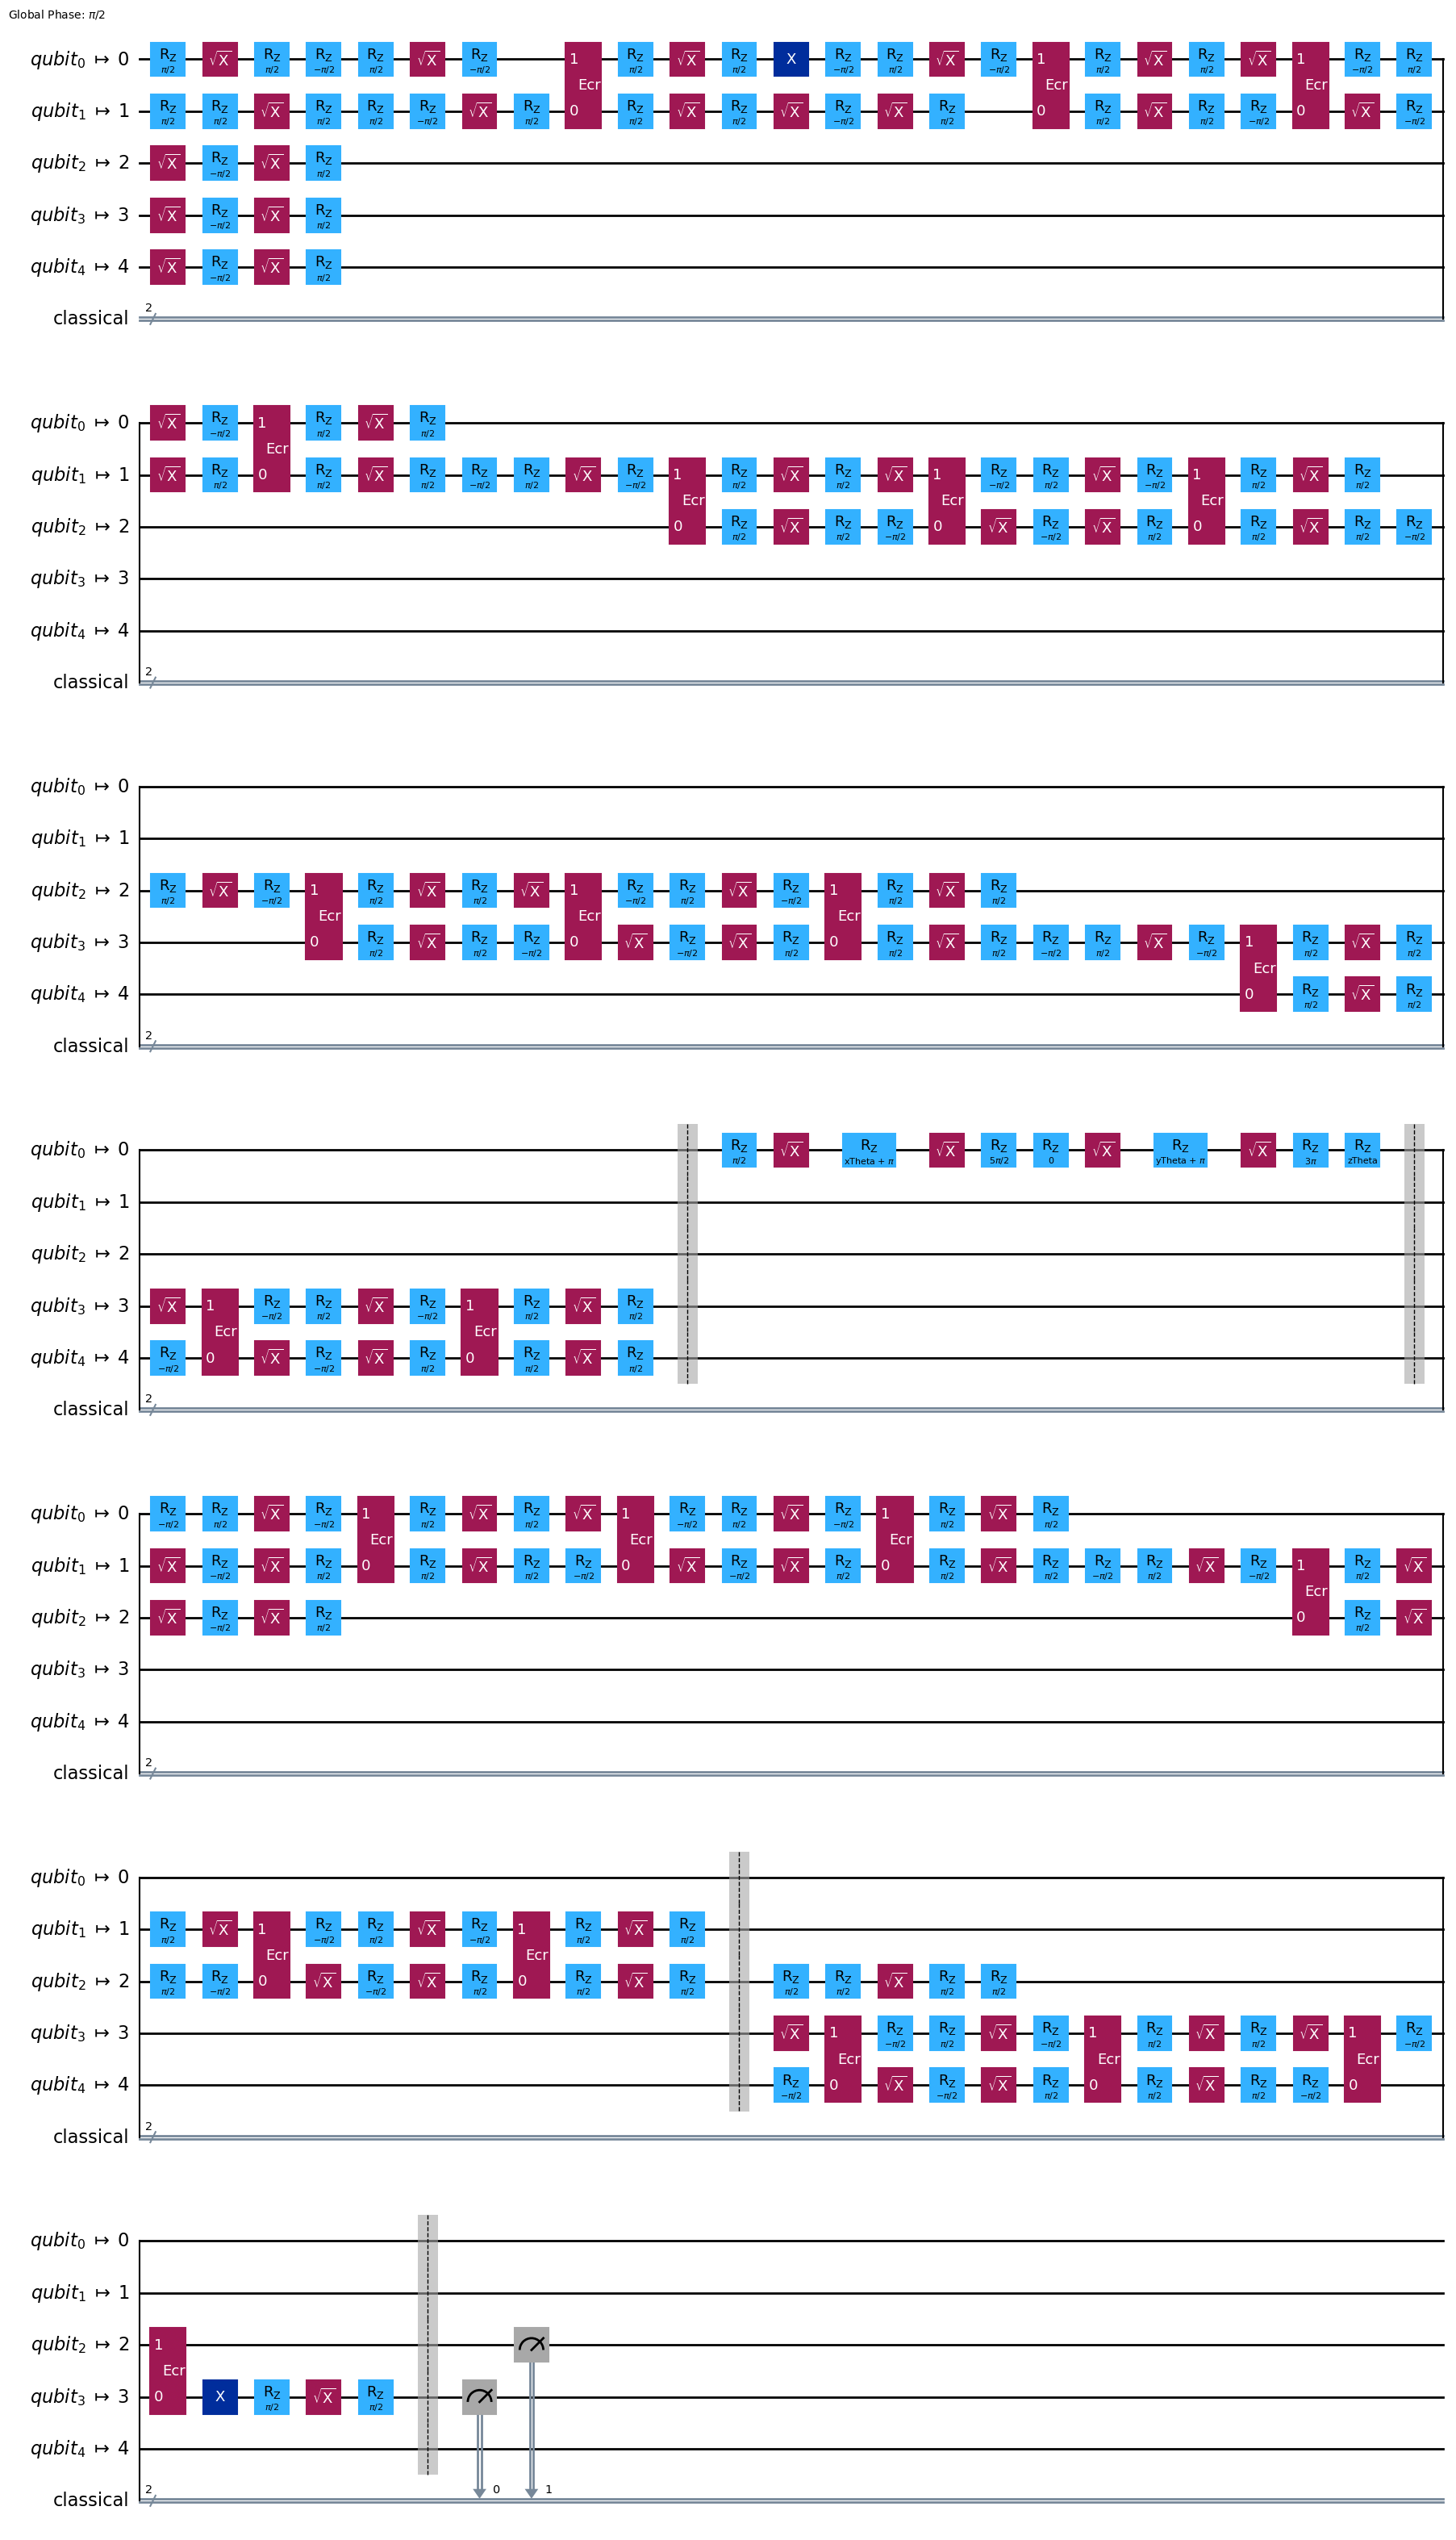

In [15]:
from qiskit_ibm_runtime.fake_provider import FakeSherbrooke
from qiskit_aer import AerSimulator
#backend = FakeSherbrooke()
#backend = AerSimulator()
backend = service.backend('ibm_brisbane')
sampler = Sampler(backend)
print(Sampler(backend))

# Create the "pass manager" that will perform the transpilation
pm = generate_preset_pass_manager(backend=backend, optimization_level=0)

# Run the pass manager to generate the transpiled circuit
transpiled_circuit = pm.run(qc)
transpiled_circuit.draw('mpl')

In [40]:
file = open("quRNG_01.txt","r")
content = file.read()
param_sets = send_string(content)
bound_circuits = [transpiled_circuit.assign_parameters(param) for param in param_sets]
job2 = sampler.run(bound_circuits, shots = 10)


In [7]:
def recieve_string(job):
    message = ""
    for i in range(len(job.result())):
        result = job.result()[i].data.classical.get_counts()
        max=0
        mess_seg = ""
        for res in result:
            if (result[res]>max):
                mess_seg = res
                max=result[res]
        message = f"{message}{mess_seg}"
        #print(job2.result()[i].data.classical.get_counts())
    return message

def recieve_string_loaded_job(job):
    message = ""
    for i in range(len(job)):
        result = job[i].data.classical.get_counts()
        max=0
        mess_seg = ""
        for res in result:
            if (result[res]>max):
                mess_seg = res
                max = result[res]
        message = f"{message}{mess_seg}"
        #print(job2.result()[i].data.classical.get_counts())
    return message

In [81]:
result = recieve_string(job2)
errors = 0
for i in range(len(content)):
    if (content[i]!=result[i]):
        errors+=1
print(100*errors/len(content))
# print(job2.result()[0].data.classical.get_counts())
# print(result)


IndexError: string index out of range

In [90]:
errors2 = []
shots = [1,2]
for i in shots:
    job2 = sampler.run(bound_circuits, shots = i)
    result = recieve_string(job2)
    error_num = 0
    for i in range(len(content)):
        if (content[i]!=result[i]):
            error_num+=1
    errors2.append(100*error_num/len(content))
print(errors2)

[14.707820738137082, 13.884007029876978]


In [ ]:
import scipy.optimize as opt
def fit_equation (x, a, b, c):
    y = a*(np.exp((-b)*x))+c
    return y
shots_fixed = [x for i, x in enumerate(shots) if i != 1]
errors_fixed = [x for i, x in enumerate(errors) if i != 1]
param, cov = opt.curve_fit(fit_equation, shots_fixed, errors_fixed)


[1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]


C:\Users\caleb\AppData\Local\Temp\ipykernel_47216\1173672898.py:3: RuntimeWarning: overflow encountered in exp
  y = a*(np.exp((-b)*x))+c


In [83]:
print(param[0])

19.831562228168433


Text(0, 0.5, 'Bit error %')

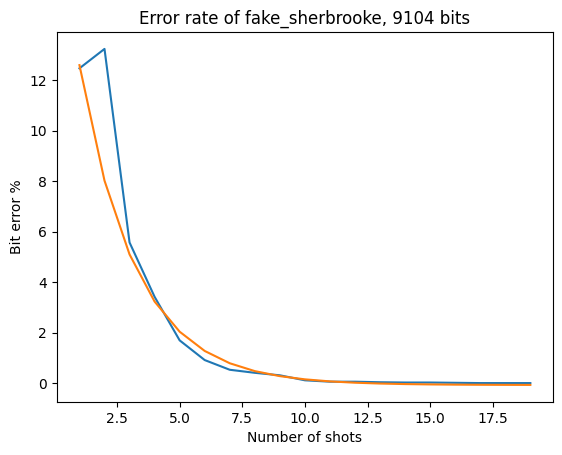

In [ ]:
plt.plot(shots, errors)
plt.plot(shots, fit_equation(shots, param[0], param[1], param[2]))
plt.title("Error rate of fake_sherbrooke, 9104 bits")
plt.xlabel("Number of shots")
plt.ylabel("Bit error %")

In [ ]:
print(len(result))

9104


In [11]:
job = service.job('d0wf200htw7g008pz23g')
result = recieve_string(job)
errors = 0
for i in range(len(content)):
    if (content[i]!=result[i]):
        errors+=1
print(100*errors/len(content))


7.8756590509666085


In [23]:
print(job.result()[2].data.classical.get_counts())

{'01': 3, '11': 4, '10': 2, '00': 1}


In [80]:
print(content)

0000111100111101111100111011110111111101001001110111110011011100111110111111011111011111000011010100010001111111101110111101000101100010101011111010111010111100101101110111100101011111101111011011111111111111011011111111100111111011010001011101111010001100011101111000111011111111101101111010111111111000111100111011000000111111111110110111011111101111110110101111011111111100110110110110110110110111001110010010010001111111110001010101011110111011110001101001101011010110101100010111111111110111011111111011001101101111101101110111111001011010011011110100111111111101001101111110111000101100001110111111001111100001111101110101111100111111110010111101111101110110001001101110010111110111111110110101100111100001011111101011111110001011101111111111010110011101111110111111101011011001111101111110111001101111111111111011111101111101010011011111010110110110110011111111011101011000111101110010110011111011111011111011111111101110111110001010111010100110100110101101001111001010011011010111000111110001

In [8]:
from PIL import Image
img = Image.open("smile.png")
pikls = list(img.getdata())
print(pikls)
strPikls=''.join(str(x) for x in pikls)
print(strPikls)


[1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 

In [9]:
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler, Batch
param_sets = send_string(strPikls)
bound_circuits = [transpiled_circuit.assign_parameters(param) for param in param_sets]
with Batch(backend=backend):
    sampler = Sampler()
    for i in range(1,15):
        sampler.run(bound_circuits, shots=i)

/opt/conda/lib/python3.11/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:857: UserWarning: IBM Quantum Platform is moving, and this version will be sunset on July 1. To get started on the new platform, read the migration guide at https://docs.quantum.ibm.com/migration-guides/classic-iqp-to-cloud-iqp
  warnings.warn(warning_message)
qiskit_runtime_service.check_pending_jobs:WARNING:2025-06-05 20:09:56,692: The pending jobs limit has been reached. Waiting for job <RuntimeJobV2('d10adcd3grvg008hnmx0', 'sampler')> to finish before submitting the next one.
qiskit_runtime_service.check_pending_jobs:WARNING:2025-06-05 20:15:12,893: The pending jobs limit has been reached. Waiting for job <RuntimeJobV2('d10adcd3grvg008hnmx0', 'sampler')> to finish before submitting the next one.


IBMRuntimeError: 'Failed to run program: \'400 Client Error: Bad Request for url: https://api.quantum.ibm.com/runtime/jobs. {"errors":[{"code":1217,"message":"Session has been closed.","solution":"Reduce time between submitting subsequent jobs in a session.","more_info":"https://docs.quantum-computing.ibm.com/errors"}]}\''

## Qubit 3 Analysis from json

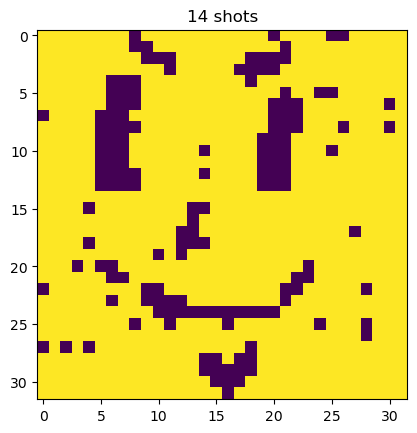

bit errors: 44
bit error rate: 4.296875


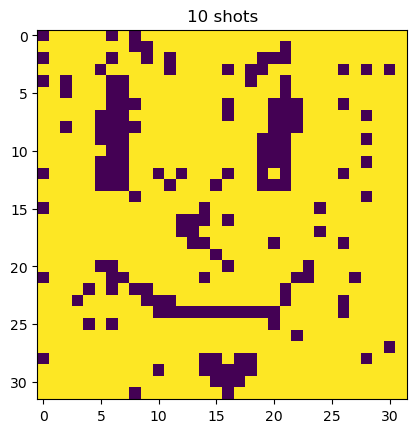

bit errors: 65
bit error rate: 6.34765625


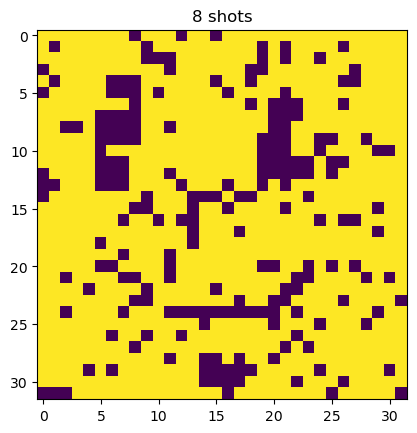

bit errors: 124
bit error rate: 12.109375


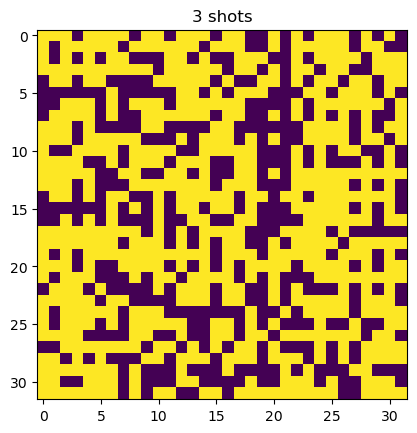

bit errors: 344
bit error rate: 33.59375


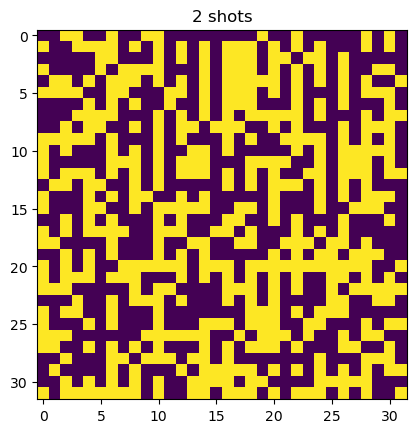

bit errors: 534
bit error rate: 52.1484375


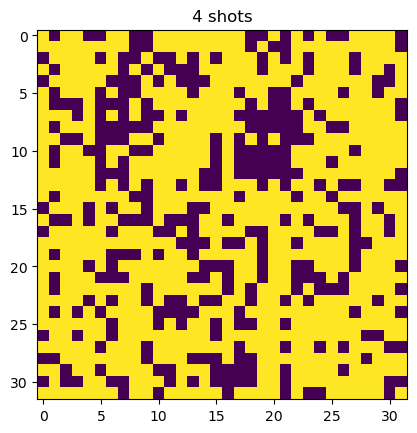

bit errors: 267
bit error rate: 26.07421875


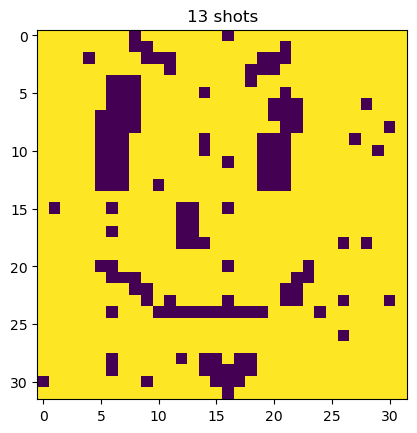

bit errors: 38
bit error rate: 3.7109375


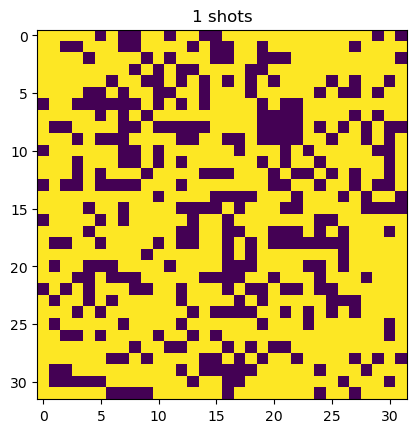

bit errors: 290
bit error rate: 28.3203125


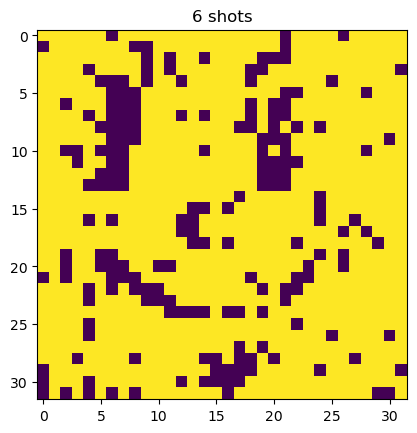

bit errors: 102
bit error rate: 9.9609375


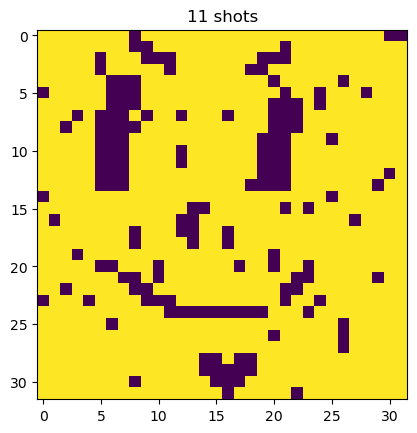

bit errors: 55
bit error rate: 5.37109375


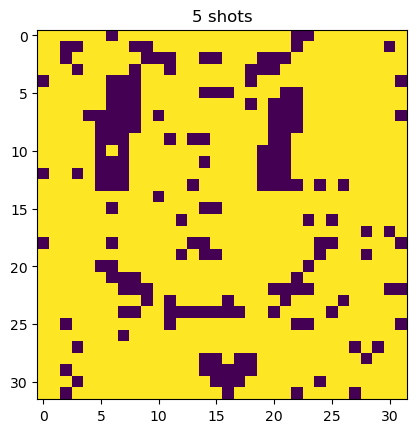

bit errors: 88
bit error rate: 8.59375


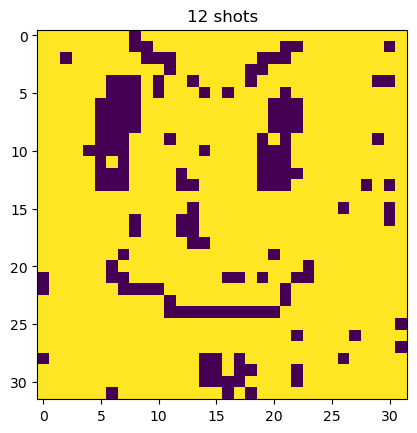

bit errors: 56
bit error rate: 5.46875


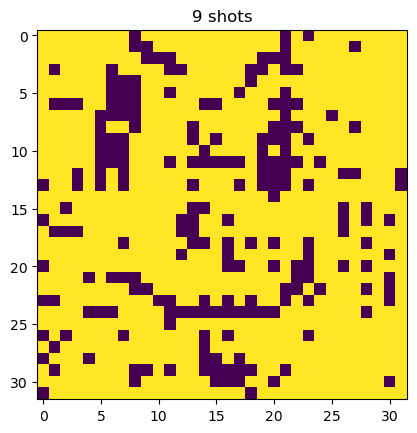

bit errors: 119
bit error rate: 11.62109375


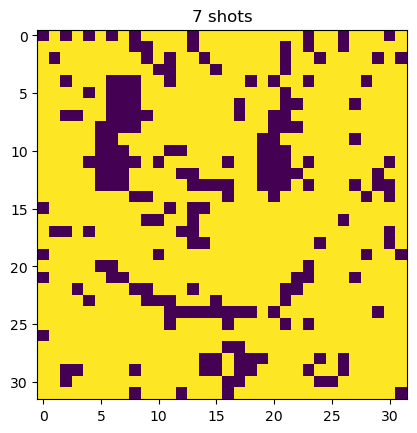

bit errors: 116
bit error rate: 11.328125


In [12]:
from qiskit_ibm_runtime.utils import RuntimeDecoder
import json
import os
for item in os.listdir('results'):
    with open(os.path.join('results', item)) as f:
        result_data = json.load(f)
    retrieved_job = json.loads(json.dumps(result_data), cls=RuntimeDecoder)
    shots_this_job = retrieved_job[0].data.classical.num_shots

    result = recieve_string_loaded_job(retrieved_job)
    arr = [int(char) for char in result]
    array = np.reshape(arr, img.size)
    plt.imshow(array, interpolation='nearest')
    plt.title(f"{shots_this_job} shots")
    plt.show()

    biterrors = 0
    for original, sent in zip(strPikls, result):
        if original != sent:
            biterrors += 1
    print(f"bit errors: {biterrors}")
    print(f"bit error rate: {(biterrors / len(strPikls)) * 100}")


## Qubit 43 Json

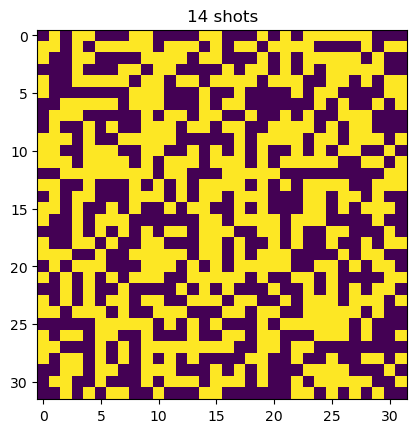

bit errors: 504
bit error rate: 49.21875


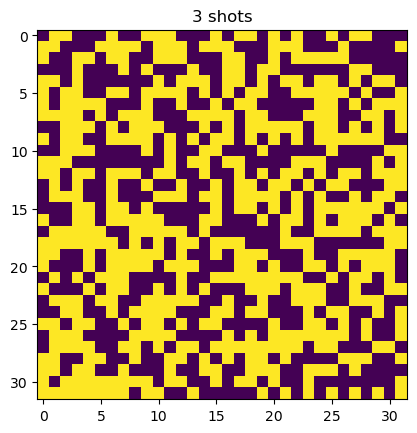

bit errors: 461
bit error rate: 45.01953125


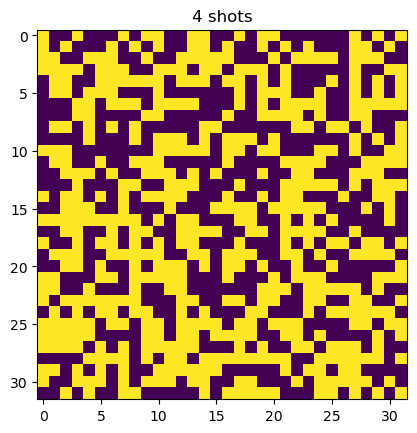

bit errors: 484
bit error rate: 47.265625


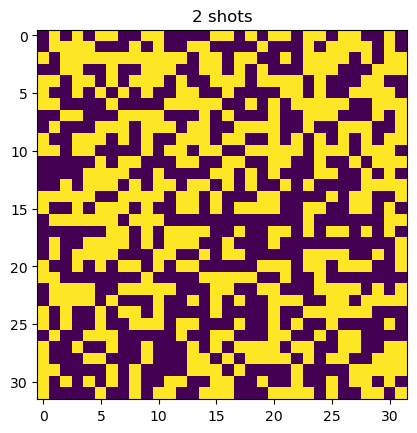

bit errors: 513
bit error rate: 50.09765625


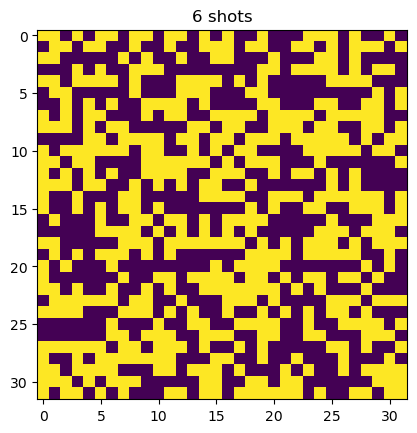

bit errors: 486
bit error rate: 47.4609375


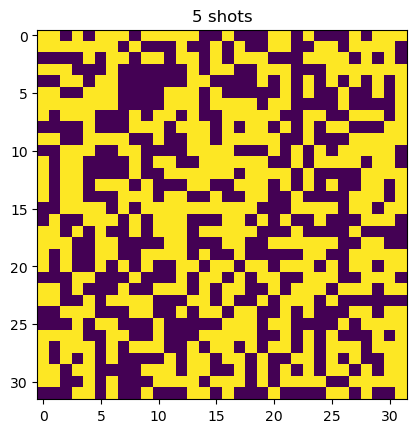

bit errors: 466
bit error rate: 45.5078125


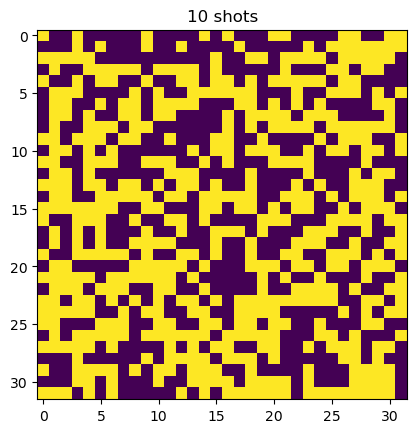

bit errors: 485
bit error rate: 47.36328125


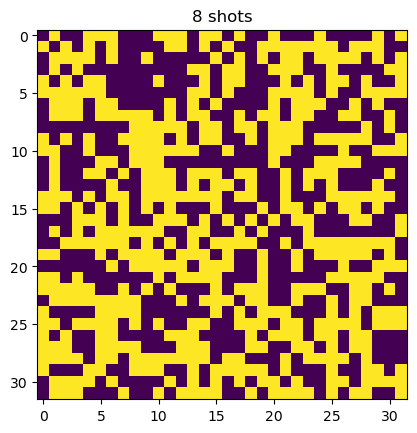

bit errors: 471
bit error rate: 45.99609375


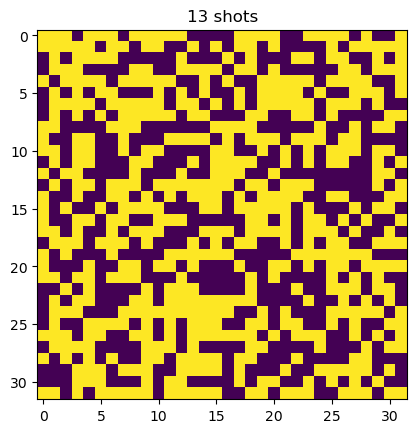

bit errors: 470
bit error rate: 45.8984375


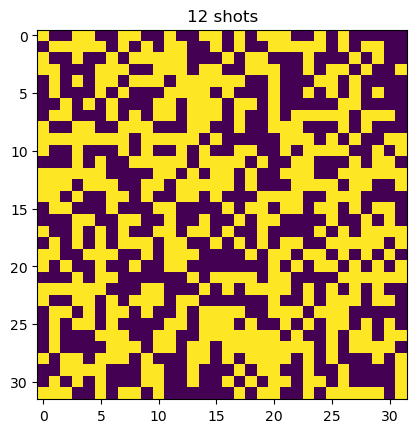

bit errors: 483
bit error rate: 47.16796875


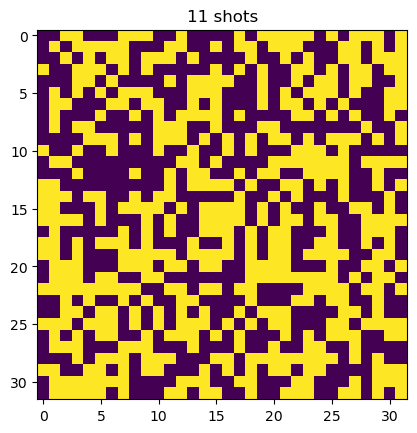

bit errors: 480
bit error rate: 46.875


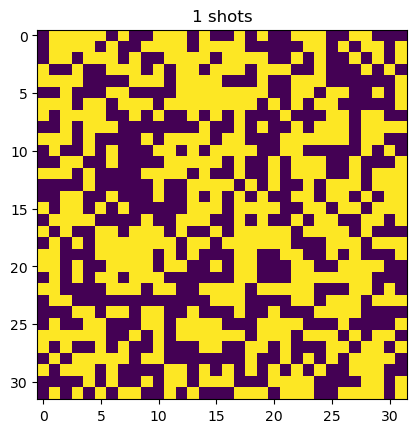

bit errors: 462
bit error rate: 45.1171875


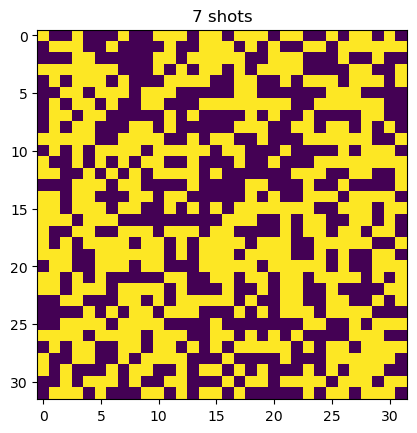

bit errors: 457
bit error rate: 44.62890625


In [14]:

for item in os.listdir('q43r1'):
    with open(os.path.join('q43r1', item)) as f:
        result_data = json.load(f)
    retrieved_job = json.loads(json.dumps(result_data), cls=RuntimeDecoder)
    shots_this_job = retrieved_job[0].data.classical.num_shots

    result = recieve_string_loaded_job(retrieved_job)
    arr = [int(char) for char in result]
    array = np.reshape(arr, img.size)
    plt.imshow(array, interpolation='nearest')
    plt.title(f"{shots_this_job} shots")
    plt.show()

    biterrors = 0
    for original, sent in zip(strPikls, result):
        if original != sent:
            biterrors += 1
    print(f"bit errors: {biterrors}")
    print(f"bit error rate: {(biterrors / len(strPikls)) * 100}")
